Total number of human proteins: 19699

contraception, breast carcinoma 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/EFO_0000305/associations?projection=associationByStudy
Genes: 252

retrieve proteins url: https://string-db.org/api/tsv-no-header/get_string_ids?identifiers=GLG1%0dRAD51L1%0dintergenic%0dFGFR2%0dMAP3K1%0dTOX3%0dESR1%0dC6orf97%0dSLC4A7%0dKLF4%0dACTL7A%0dRAD23B%0dTNRC9%0dLOC643714%0dLSP1%0dCDKN2A%0dCDKN2B%0dANKRD16%0dFBXO18%0dZNF365%0dZMIZ1%0dFGF3%0dMYEOV%0dCCND1%0dORAOV1%0dFGF19%0dFGF4%0dECHDC1%0dRNF146%0dMRPS30%0dERBB4%0dLRRN2%0dPIK3C2B%0dMDM4%0dLGR6%0dUBE2T%0dPTPN7%0dFTO%0dKIAA1752%0dTERT%0dPTHLH%0dMERIT40%0dPEX14%0dEBF1%0dNTN4%0dBRCA2%0dN4BP2L1%0dMIR1972-2%0dMKL1%0dTNIP3%0dSLC45A1%0dSIAH2%0dTCF7L2%0dNR%0dBCL2L15%0dAP4B1%0dDCLRE1B%0dHIPK1%0dPTPN22%0dMETAP1D%0dDLX1%0dDLX2%0dDIRC3%0dITPR1%0dEGOT%0dTGFBR2%0dTET2%0dADAM29%0dRAB3C%0dFOXQ1%0dRANBP9%0dARHGEF5%0dNOBOX%0dMYC%0dMIR1208%0dDNAJC1%0dMLLT10%0dDKFZp761E198%0dOVOL1%0dSNX32%0dCFL1%0dMUS81%0dN4BP2L2%0dPA

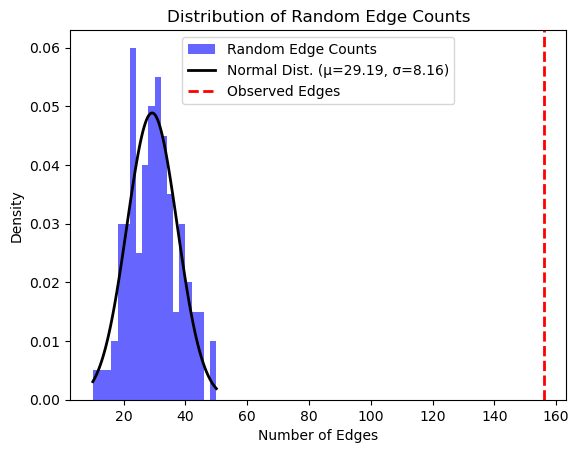

z score for a random nodes: 15.541806690387148

P-value: 0.0
--------------------------------------------



'disease3 = Disease("Schizophrenia", \'MONDO_0005090\')\nprint(disease3, \'\n\')\ndisease3.quantify_clustering()\n\ndisease1 = Disease("Alzheimer\'s Disease", \'MONDO_0004975\')\nprint(disease1, \'\n\')\ndisease1.quantify_clustering()\n\n\ndisease2 = Disease("Parkinson Disease", \'MONDO_0005180\')\nprint(disease2, \'\n\')\ndisease2.quantify_clustering()'

In [1]:
# # Huntinngton: 100 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 100)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges(self, num_nodes, iterations=100, required_score=700):
        total_edges = 0
        random_edge_counts = []
        random_interactions = []           
        for _ in range(iterations):
            random_num_edges = 0
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data.")
                
            random_edge_counts.append(random_num_edges)
        print(f'random edges url: {url}\n')
        
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges(len(self.proteins), 100, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
        '''if self.num_edges > random_edges:
            print("The disease genes show higher clustering than random nodes.")
        else:
            print("The disease genes do not show higher clustering than random nodes.")
        '''
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease5 = Disease("contraception, breast carcinoma", 'EFO_0000305')
print(disease5, '\n')
disease5.quantify_clustering()


'''disease3 = Disease("Schizophrenia", 'MONDO_0005090')
print(disease3, '\n')
disease3.quantify_clustering()

disease1 = Disease("Alzheimer's Disease", 'MONDO_0004975')
print(disease1, '\n')
disease1.quantify_clustering()


disease2 = Disease("Parkinson Disease", 'MONDO_0005180')
print(disease2, '\n')
disease2.quantify_clustering()'''


Total number of human proteins: 19699

Cataract 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/MONDO_0005129/associations?projection=associationByStudy
Genes: 73

retrieve proteins url: https://string-db.org/api/tsv-no-header/get_string_ids?identifiers=PPARD%0dCCDC102A%0dCDKN2C%0dADCK3%0dEFNA3%0dSOX2%0d0T%0dHLA-DQB1%0dTHSD7A%0dIGFBP3%0dLOC730338%0dZNF800%0dLOC157273%0dTNKS%0dCDKN2B-AS1%0dDMRTA1%0dBAMBI%0dLINC01517%0dRIC8A%0dLOC338694%0dOCA2%0dWWP2%0dPLEKHH3%0dNPLOC4%0dMETRNL%0dJAG1%0dLOC101929395%0dSLC24A3%0dLINC02429%0dMIR548AG1%0dHSPA1A46%0dADGRL2%0dCASZ1%0dFAM46C%0dLINC00970%0dTRIB2%0dPLB1%0dLRP1B%0dKYNU%0dDIRC3%0dRARB%0dATXN7%0dOT%0dC4orf22%0dBMP3%0dKCNQ5%0dCREB5%0dTNS3%0dQKI%0dBIN3%0dEGR3%0dCDKN2B%0dPLCE1%0dODF3%0dBET1L%0dCAPRIN2%0dMVK%0dFAM222A%0dSTXBP6%0dBMP4%0dRORA%0dVPS13C%0dRBFOX1%0dALDOA%0dRHOT1%0dRHBDL3%0dMIR2117HG%0dSEPT9%0dCPAMD8%0dHORMAD2%0dNR%0d5' LOC338694%0dCASP7&species=9606

Proteins: 59

Number of edges: 3

Random edges calculation completed.



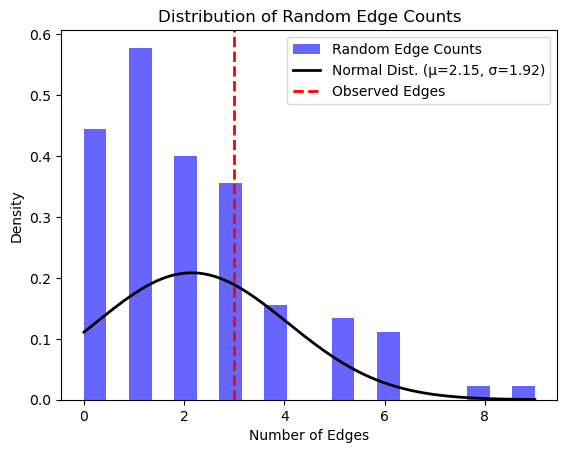

z score for a random nodes: 0.44384758832650917

P-value: 0.346
--------------------------------------------



In [3]:
# Cataract: 100 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed


STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('../data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 1000)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges_parallel(self, num_nodes, iterations=100, required_score=700):
        random_edge_counts = []  # Collect results from all iterations

        # Function to handle a single random edge count calculation
        def get_random_edges_single(iteration):
            random_num_edges = 0
            random_interactions = []
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data for random nodes.")

            return random_num_edges

        # Use ThreadPoolExecutor to parallelize the random edge retrieval
        with ThreadPoolExecutor() as executor:
            # Submit all tasks (iterations) to the pool
            future_to_iteration = {executor.submit(get_random_edges_single, i): i for i in range(iterations)}

            # Collect results as they finish
            for future in as_completed(future_to_iteration):
                try:
                    result = future.result()
                    random_edge_counts.append(result)
                except Exception as e:
                    print(f"Error in iteration: {e}")

        print(f"Random edges calculation completed.\n")
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges_parallel(len(self.proteins), 100, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
       
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease4 = Disease("Cataract", 'MONDO_0005129')
print(disease4, '\n')
disease4.quantify_clustering()


Total number of human proteins: 19699

Cataract 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/MONDO_0005129/associations?projection=associationByStudy
Genes: 73

retrieve proteins url: https://string-db.org/api/tsv-no-header/get_string_ids?identifiers=PPARD%0dCCDC102A%0dCDKN2C%0dADCK3%0dEFNA3%0dSOX2%0d0T%0dHLA-DQB1%0dTHSD7A%0dIGFBP3%0dLOC730338%0dZNF800%0dLOC157273%0dTNKS%0dCDKN2B-AS1%0dDMRTA1%0dBAMBI%0dLINC01517%0dRIC8A%0dLOC338694%0dOCA2%0dWWP2%0dPLEKHH3%0dNPLOC4%0dMETRNL%0dJAG1%0dLOC101929395%0dSLC24A3%0dLINC02429%0dMIR548AG1%0dHSPA1A46%0dADGRL2%0dCASZ1%0dFAM46C%0dLINC00970%0dTRIB2%0dPLB1%0dLRP1B%0dKYNU%0dDIRC3%0dRARB%0dATXN7%0dOT%0dC4orf22%0dBMP3%0dKCNQ5%0dCREB5%0dTNS3%0dQKI%0dBIN3%0dEGR3%0dCDKN2B%0dPLCE1%0dODF3%0dBET1L%0dCAPRIN2%0dMVK%0dFAM222A%0dSTXBP6%0dBMP4%0dRORA%0dVPS13C%0dRBFOX1%0dALDOA%0dRHOT1%0dRHBDL3%0dMIR2117HG%0dSEPT9%0dCPAMD8%0dHORMAD2%0dNR%0d5' LOC338694%0dCASP7&species=9606

Proteins: 59

Number of edges: 3

Random edges calculation completed.



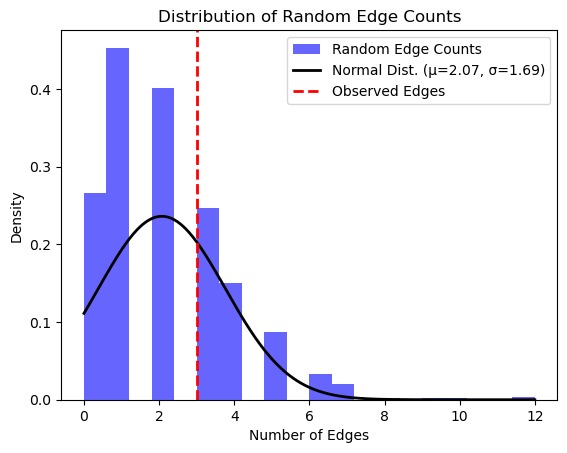

z score for a random nodes: 0.5489465052626171

P-value: 0.346
--------------------------------------------



In [4]:
# Cataract: 1000 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed


STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('../data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 1000)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges_parallel(self, num_nodes, iterations=100, required_score=700):
        random_edge_counts = []  # Collect results from all iterations

        # Function to handle a single random edge count calculation
        def get_random_edges_single(iteration):
            random_num_edges = 0
            random_interactions = []
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data for random nodes.")

            return random_num_edges

        # Use ThreadPoolExecutor to parallelize the random edge retrieval
        with ThreadPoolExecutor() as executor:
            # Submit all tasks (iterations) to the pool
            future_to_iteration = {executor.submit(get_random_edges_single, i): i for i in range(iterations)}

            # Collect results as they finish
            for future in as_completed(future_to_iteration):
                try:
                    result = future.result()
                    random_edge_counts.append(result)
                except Exception as e:
                    print(f"Error in iteration: {e}")

        print(f"Random edges calculation completed.\n")
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges_parallel(len(self.proteins), 1000, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
       
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease4 = Disease("Cataract", 'MONDO_0005129')
print(disease4, '\n')
disease4.quantify_clustering()

Total number of human proteins: 19699

Huntington Disease 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/MONDO_0007739/associations?projection=associationByStudy
Genes: 49

retrieve proteins url: https://string-db.org/api/tsv-no-header/get_string_ids?identifiers=DHX35%0dFAM83D%0dLOC339568%0dPPP1R16B%0dADD1%0dMFSD10%0dNOP14%0dNOP14-AS1%0dSH3BP2%0dPTPRM%0dCTB-178M22.2%0dTENM2%0dMTERFD1%0dPTDSS1%0dUQCRB%0dBRF1%0dEFR3A%0dOC90%0dMSH3%0dLINC01098%0dLINC01099%0dAQP1%0dFAM188B%0dINMT-FAM188B%0dFGFR1OP%0dMIR3939%0dRNASET2%0dIntergenic%0dFAN1%0dMTMR10%0dTRPM1%0dATRNL1%0dST8SIA6%0dST8SIA6-AS1%0dDHFR%0dMTRNR2L2%0dADGB%0dCCDC12%0dKIF9%0dKIF9-AS1%0dKLHL18%0dNBEAL2%0dNRADDP%0dSETD2%0dOR2D2%0dOR10A2%0dOR10A4%0dOR10A5%0dNR&species=9606

Proteins: 39

Number of edges: 8

Random edges calculation completed.



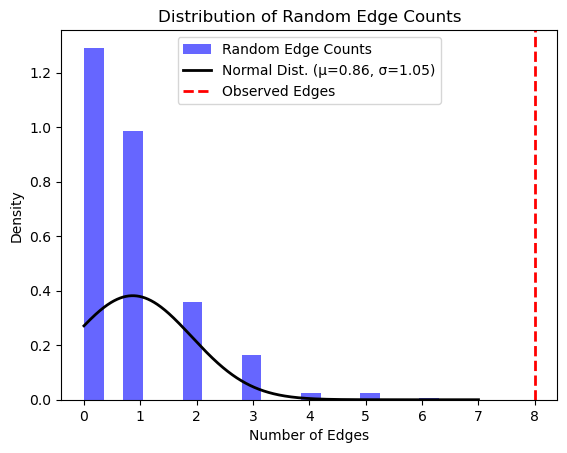

z score for a random nodes: 6.825407762100394

P-value: 1.13e-06
--------------------------------------------



In [7]:
# Huntinngton: 1000 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed


STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('../data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 1000)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges_parallel(self, num_nodes, iterations=100, required_score=700):
        random_edge_counts = []  # Collect results from all iterations

        # Function to handle a single random edge count calculation
        def get_random_edges_single(iteration):
            random_num_edges = 0
            random_interactions = []
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data for random nodes.")

            return random_num_edges

        # Use ThreadPoolExecutor to parallelize the random edge retrieval
        with ThreadPoolExecutor() as executor:
            # Submit all tasks (iterations) to the pool
            future_to_iteration = {executor.submit(get_random_edges_single, i): i for i in range(iterations)}

            # Collect results as they finish
            for future in as_completed(future_to_iteration):
                try:
                    result = future.result()
                    random_edge_counts.append(result)
                except Exception as e:
                    print(f"Error in iteration: {e}")

        print(f"Random edges calculation completed.\n")
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges_parallel(len(self.proteins), 1000, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
       
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease5 = Disease("Huntington Disease", 'MONDO_0007739')
print(disease5, '\n')
disease5.quantify_clustering()


Total number of human proteins: 19699

Alzheimer's Disease 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/MONDO_0004975/associations?projection=associationByStudy
Genes: 322

%0dCDON%0dATXN7L1%0dMPZL1%0dCEACAM16%0dBCL3%0dPPP1R37%0dBMPER%0dSLC8A1-AS1%0dCYB561%0dACE%0dIL6R%0dTDRD10%0dSHE%0dUBE2Q1%0dADAR%0dCCRL2%0dCCR5%0dCCR2%0dLTF%0dCCR3%0dMMP3%0dMMP12%0dWTAPP1%0dMMP13%0dDCUN1D5%0dCCBP2%0dPCDH11X%0dEPC2%0dCCDC134%0dLOC100129500%0dCD33%0dMS4A%0dCDKAL1%0dDST%0dCDC5L%0dC6orf203%0dKCNN2%0dHTR7%0dZNF273%0dFARP1%0dSMEK1%0dZNF599%0dSIK1%0dDKFZP434H0512%0dFOXE1%0dGRIN3A%0dOSBPL6%0dMLK4%0dNR3C2%0dSH3RF1%0dFAT1%0dFGF10%0dDDX18%0dZNF804A%0dLINC00692%0dPTPRG%0dFANCD2%0dFANCD2OS%0dMS4A3%0dBCAM%0dPVR%0dEXOC3L2%0dFAM113B%0dZNF224%0dDISC1%0dUTS2D%0dSNAR-I%0dGEMC1%0dOSTNIL1-RAP%0dCCDC50%0dGLIS3%0dTREM%0dNCR2%0dFRMD4A%0dSEMA3C%0dCNTNAP5%0dFAM46A%0dFBXL7%0dCACNA2D3%0dPRRC2C%0dLIMS2%0dMOBP%0dSTK32B%0dCTNNA2%0dAFF1%0dFMN2%0dANKRD55%0dPGAM5P1%0dMAN2A1%0dDMXL1%0dCAMK4%0dMEGF10%0dFLJ33630%0dSAP3

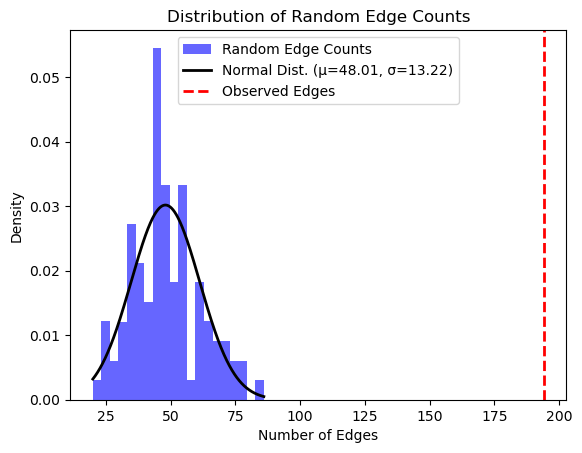

z score for a random nodes: 11.03927987133181

P-value: 0.0
--------------------------------------------



In [6]:
# Alzheimer's: 100 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed


STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('../data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 1000)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges_parallel(self, num_nodes, iterations=100, required_score=700):
        random_edge_counts = []  # Collect results from all iterations

        # Function to handle a single random edge count calculation
        def get_random_edges_single(iteration):
            random_num_edges = 0
            random_interactions = []
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data for random nodes.")

            return random_num_edges

        # Use ThreadPoolExecutor to parallelize the random edge retrieval
        with ThreadPoolExecutor() as executor:
            # Submit all tasks (iterations) to the pool
            future_to_iteration = {executor.submit(get_random_edges_single, i): i for i in range(iterations)}

            # Collect results as they finish
            for future in as_completed(future_to_iteration):
                try:
                    result = future.result()
                    random_edge_counts.append(result)
                except Exception as e:
                    print(f"Error in iteration: {e}")

        print(f"Random edges calculation completed.\n")
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges_parallel(len(self.proteins), 100, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
       
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease1 = Disease("Alzheimer's Disease", 'MONDO_0004975')
print(disease1, '\n')
disease1.quantify_clustering()


Total number of human proteins: 19699

Parkinson Disease 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/MONDO_0005180/associations?projection=associationByStudy
Genes: 350

CNNM2%0dCYP17A1%0dBMP4%0dMMRN1%0dSLC45A3%0dPM20D1%0dRAB7L1%0dSLC41A1%0dDDRGK1%0dFGF20%0dVPS13C%0dBCKDK%0dSTX1B%0dTMEM229B%0dSPPL2B%0dGCH1%0dSIPA1L2%0dTMEM163%0dTMEM175%0dDGKQ%0dSCARB2%0dFAM47E%0dHLA-DQB%0dGPNMB%0dINPP5F%0dMIR4697%0dSTH%0dBRDG1%0dCRHR1%0dLRRC37A3%0dPKP2%0dSYT10%0dHLA-DQA1%0dCERS6%0dFAM126A%0dKLHL7%0dTIAL1%0dBAG3%0dCD38%0dZNF184%0dHIST1H2BL%0dCTNND1%0dOR9Q1%0dPRICKLE1%0dADAMTS20%0dSH3GL2%0dSYT17%0dCLEC19A%0dNDUFAF2%0dCA8%0dHSD17B1%0dGLU%0dFLJ43860%0dNCRNA00051%0dBARX1%0dPTPDC1%0dDMRT2%0dSMARCA2%0dFLJ35379%0dLOC100132423%0dPRDM2%0dKIAA1026%0dATPBD4%0dLOC100288892%0dC18orf1%0dANXA1%0dLOC100130911%0dZFP64%0dTSHZ2%0dZNF396%0dINO80C%0dMDGA2%0dWNT9A%0dLOC728728%0dCYP1B1%0dC2orf58%0dPLEKHN1%0dFLJ23172%0dFNDC3B%0dPAQR3%0dARD1B%0dPDE10A%0dTSG1%0dMANEA%0dCOL5A2%0dC3orf67%0dLOC339902%0dLOC285194%

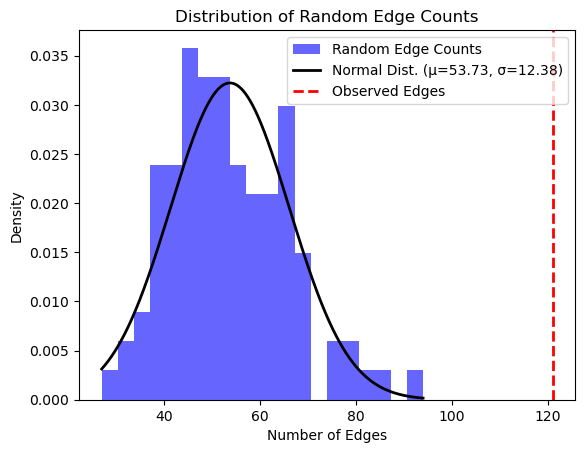

z score for a random nodes: 5.435667216948501

P-value: 0.0
--------------------------------------------



In [8]:
# Parkinson: 100 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed


STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('../data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 1000)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges_parallel(self, num_nodes, iterations=100, required_score=700):
        random_edge_counts = []  # Collect results from all iterations

        # Function to handle a single random edge count calculation
        def get_random_edges_single(iteration):
            random_num_edges = 0
            random_interactions = []
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data for random nodes.")

            return random_num_edges

        # Use ThreadPoolExecutor to parallelize the random edge retrieval
        with ThreadPoolExecutor() as executor:
            # Submit all tasks (iterations) to the pool
            future_to_iteration = {executor.submit(get_random_edges_single, i): i for i in range(iterations)}

            # Collect results as they finish
            for future in as_completed(future_to_iteration):
                try:
                    result = future.result()
                    random_edge_counts.append(result)
                except Exception as e:
                    print(f"Error in iteration: {e}")

        print(f"Random edges calculation completed.\n")
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges_parallel(len(self.proteins), 100, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
       
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease2 = Disease("Parkinson Disease", 'MONDO_0005180')
print(disease2, '\n')
disease2.quantify_clustering()

Total number of human proteins: 19699

Type 2 diabetes 

Get genes url: https://www.ebi.ac.uk/gwas/rest/api/efoTraits/MONDO_0005148/associations?projection=associationByStudy
Genes: 295

retrieve proteins url: https://string-db.org/api/tsv-no-header/get_string_ids?identifiers=TCF7L2%0dSLC30A8%0dCDKAL1%0dCDC123%0dCAMK1D%0dSPRY2%0dHHEX%0dC2CD4B%0dNR%0dFTO%0dROR2%0dOSBPL1A%0dLIMS2%0dDAAM1%0dIGF2BP2%0dJAZF1%0dCDKN2A%0dCDKN2B%0dMHC%0dMACF1%0dTOMM40%0dAPOE%0dANKRD55%0dKCNJ11%0dPPARG%0dintergenic%0dMARCH1%0dPCNXL2%0dLPIN2%0dHMG20A%0dHUNK%0dKIF11%0dPEX5L%0dCR2%0dC6orf57%0dACHE%0dTCERG1L%0dZPLD1%0dFLJ16165%0dPLS1%0dGPSM1%0dTLE1%0dZMIZ1%0dIDE%0dKCNQ1%0dARAP1%0dCENTD2%0dKLHDC5%0dPRC1%0dSLC16A13%0dHNF1B%0dTCF2%0dGIPR%0dC2CD4A/B%0dHNF1A%0dFAF1%0dGCKR%0dFAM60A%0dASB3%0dDMRTA1%0dATP8B2%0dMIR4686%0dINAFM2%0dRPL19P16%0dC16orf74%0dADH5P4%0dZBTB20%0dKIAA1456%0dSALL4P5%0dCCDC85A%0dUBE2E2%0dPSMD6%0dADCY5%0dIGFBP2%0dMAEA%0dGCC1%0dFSCN3%0dPAX4%0dMIR129%0dLEP%0dANK1%0dGLIS3%0dTLE4%0dIG2BP2%0dHLA-DQA2%0dLAMA1%

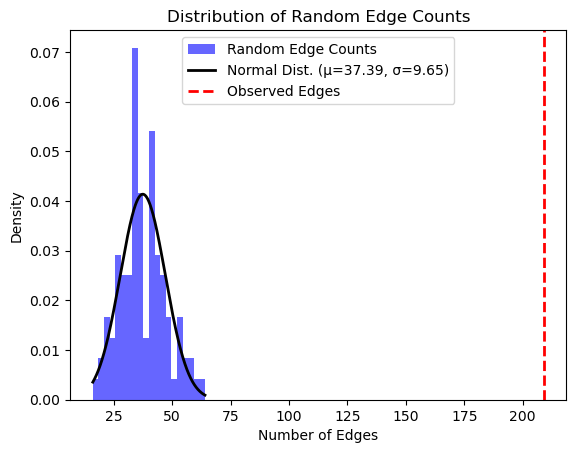

z score for a random nodes: 17.78959116734807

P-value: 0.0
--------------------------------------------



In [9]:
# type 2 diabetes: 100 iterations
import requests
import pandas as pd
import random
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed


STRING_API_URL = "https://string-db.org/api"
OUTPUT_FORMAT = "tsv-no-header"
SPECIES = "9606"
REQUIRED_SCORE = 700

aliases_df = pd.read_csv('../data/9606.protein.aliases.v12.0.txt', sep='\t')
ALL_PROTEINS = set(aliases_df['string_protein_id'].unique().tolist())

print(f"Total number of human proteins: {len(ALL_PROTEINS)}\n")

def get_z_score(random_edges, observed_edges):
    mean = np.mean(random_edges)
    std = np.std(random_edges)
    z_score = (observed_edges - mean) / std
    plot(random_edges=random_edges, observed_edges=observed_edges, mean=mean, std=std)
    return z_score

def plot(random_edges, observed_edges, mean, std):
    x = np.linspace(min(random_edges), max(random_edges), 1000)
    pdf = norm.pdf(x, mean, std)
    plt.hist(random_edges, bins=20, density=True, alpha=0.6, color='blue', label="Random Edge Counts")
    plt.plot(x, pdf, 'k-', lw=2, label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')
    plt.axvline(observed_edges, color='red', linestyle='dashed', linewidth=2, label="Observed Edges")

    plt.title('Distribution of Random Edge Counts')
    plt.xlabel('Number of Edges')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


class Disease:
    def __init__(self, name, efo_id):
        self.name = name
        self.efo_id = efo_id
        self.genes = []
        self.proteins = []
        self.interactions = []
        self.num_edges = 0
    
    def __str__(self):
        return self.name

    def send_request(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response
        else:
            print(f"Failed to retrieve data: {response.status_code}\n")
            return None
        
    def send_post_request(self, url, data):
        try:
            response = requests.post(url, data=data)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Failed to retrieve data: {e}")
            return None

    def get_genes(self):
        api_url = 'https://www.ebi.ac.uk/gwas/rest/api'
        url = f'{api_url}/efoTraits/{self.efo_id}/associations?projection=associationByStudy'
        return url

    def get_proteins(self, genes):
        query = "%0d".join(genes)
        url = f"{STRING_API_URL}/{OUTPUT_FORMAT}/get_string_ids?identifiers={query}&species={SPECIES}"
        print(f'retrieve proteins url: {url}\n')
        return url
    
    def get_clustering(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
    
    def get_clustering_image(self, proteins, method = 'network'):
        identifiers = "%0d".join(proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, 'image', method])
        return request_url, data

    def get_random_edges_parallel(self, num_nodes, iterations=100, required_score=700):
        random_edge_counts = []  # Collect results from all iterations

        # Function to handle a single random edge count calculation
        def get_random_edges_single(iteration):
            random_num_edges = 0
            random_interactions = []
            random_proteins = random.sample(list(ALL_PROTEINS), num_nodes)
            url, data = self.get_clustering(random_proteins)
            response = self.send_post_request(url, data)
            
            if response:
                interactions = response.text.split("\n")
                for interaction in interactions:
                    if interaction.strip():
                        random_interactions.append(interaction)
                interaction_data = [line.split("\t") for line in interactions if line]
                random_num_edges += len(interaction_data)
            else:
                print("Failed to retrieve clustering data for random nodes.")

            return random_num_edges

        # Use ThreadPoolExecutor to parallelize the random edge retrieval
        with ThreadPoolExecutor() as executor:
            # Submit all tasks (iterations) to the pool
            future_to_iteration = {executor.submit(get_random_edges_single, i): i for i in range(iterations)}

            # Collect results as they finish
            for future in as_completed(future_to_iteration):
                try:
                    result = future.result()
                    random_edge_counts.append(result)
                except Exception as e:
                    print(f"Error in iteration: {e}")

        print(f"Random edges calculation completed.\n")
        return random_edge_counts
    
    def get_ppi_enrichment(self, method='ppi_enrichment'):
        identifiers = "%0d".join(self.proteins)
        data = {'identifiers': identifiers,
                'species': SPECIES,
                'required_score': REQUIRED_SCORE
            }
        request_url = "/".join([STRING_API_URL, OUTPUT_FORMAT, method])
        return request_url, data
        
    def quantify_clustering(self):
        # Retrieve genes
        response = self.send_request(self.get_genes())
        print(f'Get genes url: {self.get_genes()}')
        count = 0
        if response:
            associations = response.json()['_embedded']['associations']
            for association in associations:
                loci = association['loci']
                for locus in loci:
                    author_reported_genes = locus['authorReportedGenes']
                    for gene in author_reported_genes:
                        gene_name = gene['geneName']
                        count += 1
                        if count <= 800:
                            self.genes.append(gene_name)
            self.genes = list(dict.fromkeys(self.genes))
            print(f"Genes: {len(self.genes)}\n")
        
        # Retrieve protein mappings
        response = self.send_request(self.get_proteins(self.genes))
        if response:
            protein_mappings = response.text.split("\n")
            for line in protein_mappings:
                if line.strip(): 
                    fields = line.split("\t")
                    if len(fields) > 1:
                        protein_id = fields[1]  
                        self.proteins.append(protein_id)
            self.proteins = list(dict.fromkeys(self.proteins))
            print(f"Proteins: {len(self.proteins)}\n")
        else:
            print("Failed to retrieve protein mappings.")

        # For clustering the proteins
        url, data = self.get_clustering(self.proteins)
        response = self.send_post_request(url, data)
        if response:
            interactions = response.text.split("\n")
            for interaction in interactions:
                if interaction.strip():
                    self.interactions.append(interaction)
            interaction_data = [line.split("\t") for line in interactions if line]
            self.num_edges += len(interaction_data)
        else:
            print("Failed to retrieve clustering data.")
        print(f"Number of edges: {self.num_edges}\n")
        
        # For retrieveing the network image
        url, data = self.get_clustering_image(self.proteins)
        response = self.send_post_request(url, data)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.show()
        
        # Compare to random set of protein clustering
        random_edge_counts = self.get_random_edges_parallel(len(self.proteins), 100, 700)
        print(f"z score for a random nodes: {get_z_score(random_edge_counts, self.num_edges)}\n")
        
       
        # For ppi enrichment
        url, data = self.get_ppi_enrichment()
        response = self.send_post_request(url, data)
        if response:
            try:
                for line in response.text.strip().split("\n"):
                    columns = line.split("\t")
                    if len(columns) > 5:
                        pvalue = columns[5]
                        print("P-value:", pvalue)
                    else:
                        print("Unexpected response format:", line)
            except Exception as e:
                print(f"Error parsing response: {e}")
        else:
            print("Failed to retrieve PPI enrichment data.")
        print('--------------------------------------------\n')
        
# Usage
disease2 = Disease("Type 2 diabetes", 'MONDO_0005148')
print(disease2, '\n')
disease2.quantify_clustering()